In [352]:
import pandas as pd 
import glob
import cv2 as cv
import random

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


# Make DataFrame

## columns: review_img_path, product_img_path, label
---

In [353]:
all_product_img_list = glob.glob('./masked_data/product_img/*')
all_product_img_list = sorted(all_product_img_list)
# print(all_product_img_list)

['./masked_data/product_img/0.jpg', './masked_data/product_img/1.jpg', './masked_data/product_img/10.jpg', './masked_data/product_img/100.jpg', './masked_data/product_img/12.jpg', './masked_data/product_img/13.jpg', './masked_data/product_img/14.jpg', './masked_data/product_img/15.jpg', './masked_data/product_img/20.jpg', './masked_data/product_img/25.jpg', './masked_data/product_img/28.jpg', './masked_data/product_img/30.jpg', './masked_data/product_img/33.jpg', './masked_data/product_img/34.jpg', './masked_data/product_img/35.jpg', './masked_data/product_img/36.jpg', './masked_data/product_img/37.jpg', './masked_data/product_img/39.jpg', './masked_data/product_img/4.jpg', './masked_data/product_img/40.jpg', './masked_data/product_img/41.jpg', './masked_data/product_img/42.jpg', './masked_data/product_img/43.jpg', './masked_data/product_img/45.jpg', './masked_data/product_img/46.jpg', './masked_data/product_img/48.jpg', './masked_data/product_img/49.jpg', './masked_data/product_img/5.

In [354]:
review_img_path = []
product_img_path = []
label = []
for product_img in all_product_img_list:
    glob_img_list = []
    str = product_img.split("/")[3]
    str = str.split(".")[0]
    glob_img_list = glob.glob('./masked_data/review_img/'+str +'_review_img/O/*.jpg')
    review_img_path = review_img_path + glob_img_list
    product_img_path = product_img_path + [product_img  for i in range(len(glob_img_list))]

In [355]:
print(len(product_img_path))
print(len(review_img_path))


5389
5389


In [356]:
for i in range(len(review_img_path)):
    random_number = random.randint(0, 1)
    if random_number == 0:
        label.append(0)
    else:
        random_number = random.randint(0, len(all_product_img_list) - 1)
        product_img_path[i] = all_product_img_list[random_number]
        label.append(1)

In [357]:
df = pd.DataFrame(columns=['review_img_path','product_img_path', 'label'])
df['review_img_path'] = review_img_path
df['product_img_path'] = product_img_path
df['label'] = label

df

,review_img_path,product_img_path,label
0,./masked_data/review_img/0_review_img/O/404.jpg,./masked_data/product_img/0.jpg,0
1,./masked_data/review_img/0_review_img/O/174.jpg,./masked_data/product_img/0.jpg,0
2,./masked_data/review_img/0_review_img/O/93.jpg,./masked_data/product_img/0.jpg,0
3,./masked_data/review_img/0_review_img/O/177.jpg,./masked_data/product_img/0.jpg,0
4,./masked_data/review_img/0_review_img/O/399.jpg,./masked_data/product_img/0.jpg,0
...,...,...,...
5384,./masked_data/review_img/98_review_img/O/194.jpg,./masked_data/product_img/98.jpg,0
5385,./masked_data/review_img/98_review_img/O/148.jpg,./masked_data/product_img/98.jpg,0
5386,./masked_data/review_img/98_review_img/O/401.jpg,./masked_data/product_img/78.jpg,1
5387,./masked_data/review_img/98_review_img/O/433.jpg,./masked_data/product_img/98.jpg,0


---

# Siames Net

In [358]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [359]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,review_img_path,product_img_path,label,transform=None):
        self.review_img_path = review_img_path
        self.product_img_path = product_img_path
        self.label = label
        self.transform = transform
        
        
        
    def __getitem__(self,index):
        # review_img = cv.imread(self.review_img_path[index],cv.COLOR_BGR2GRAY)
        # product_img = cv.imread(self.product_img_path[index], cv.COLOR_BGR2GRAY)
        review_img = Image.open(self.review_img_path[index])
        product_img = Image.open(self.product_img_path[index])
        review_img = review_img.convert("L")
        product_img = product_img.convert("L")
        

        if self.transform is not None:
            review_img = self.transform(review_img)
            product_img = self.transform(product_img)
        # print(np.array([int(label[index])], dtype=np.float32))
        return review_img, product_img, torch.from_numpy(np.array([int(label[index])], dtype=np.float32))
    
    def __len__(self):
        return len(self.review_img_path)

In [360]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(df["review_img_path"].values, 
                                        df["product_img_path"].values,
                                        df["label"].values,
                                        transform=transformation)

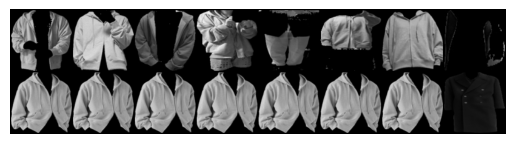

[0. 0. 0. 0. 0. 0. 0. 1.]


In [361]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [362]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [363]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [364]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=5389)

In [365]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

torch.Size([5389, 1, 100, 100])
Epoch number 0
 Current loss 1.9877921342849731

torch.Size([5389, 1, 100, 100])
Epoch number 1
 Current loss 1.8838653564453125

torch.Size([5389, 1, 100, 100])
Epoch number 2
 Current loss 1.6346454620361328

torch.Size([5389, 1, 100, 100])
Epoch number 3
 Current loss 1.5585306882858276

torch.Size([5389, 1, 100, 100])
Epoch number 4
 Current loss 1.5814388990402222

torch.Size([5389, 1, 100, 100])
Epoch number 5
 Current loss 1.5005862712860107

torch.Size([5389, 1, 100, 100])
Epoch number 6
 Current loss 1.5378650426864624

torch.Size([5389, 1, 100, 100])
Epoch number 7
 Current loss 1.5524545907974243

torch.Size([5389, 1, 100, 100])
Epoch number 8
 Current loss 1.5246623754501343

torch.Size([5389, 1, 100, 100])
Epoch number 9
 Current loss 1.4861164093017578

torch.Size([5389, 1, 100, 100])
Epoch number 10
 Current loss 1.5132098197937012

torch.Size([5389, 1, 100, 100])
Epoch number 11
 Current loss 1.496972680091858

torch.Size([5389, 1, 100, 1

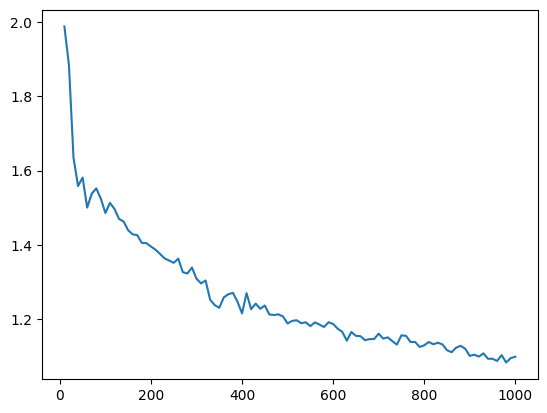

In [366]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):
        print(img0.shape)

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

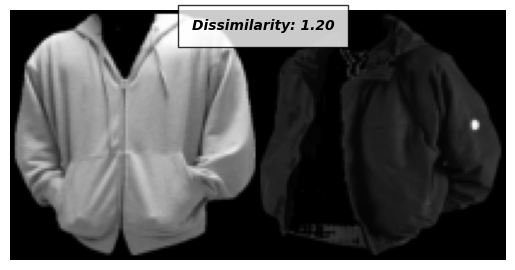

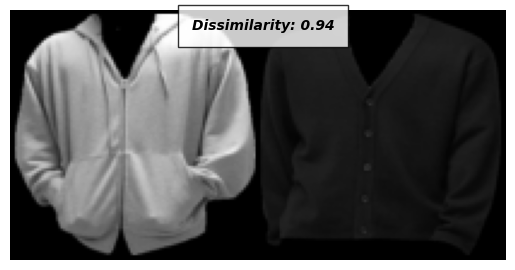

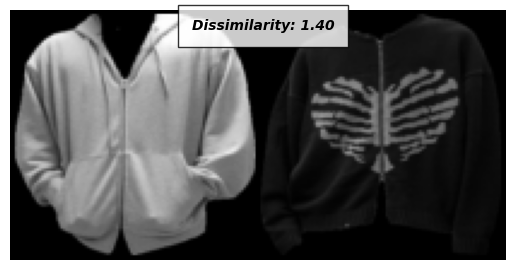

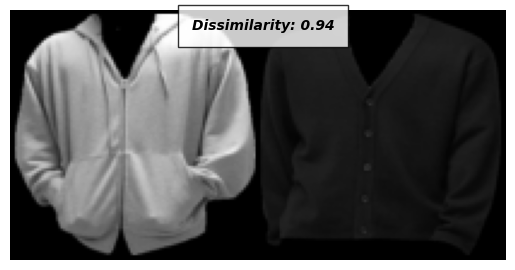

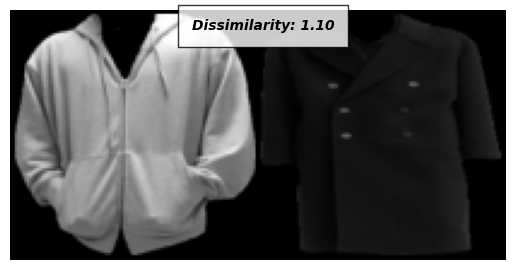

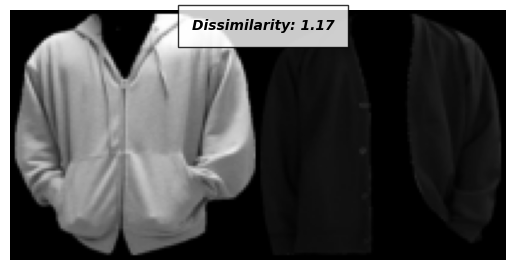

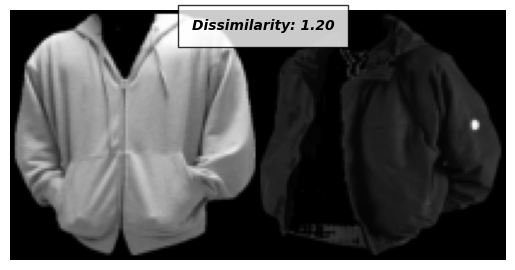

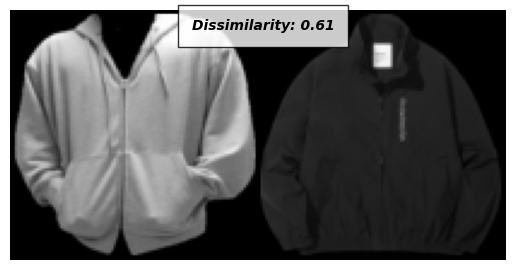

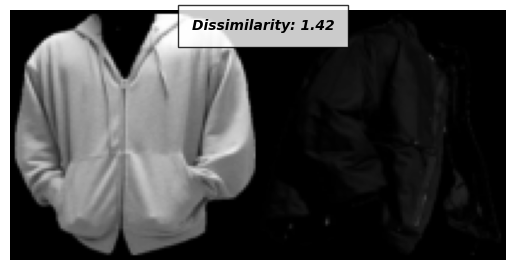

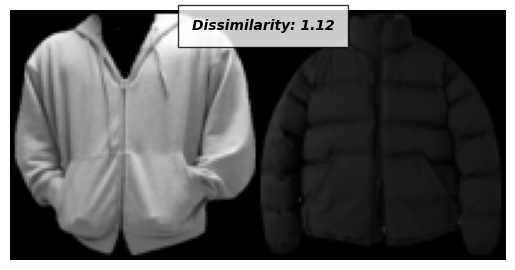

In [368]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./output/val")
siamese_dataset = SiameseNetworkDataset(df["review_img_path"].values, 
                                        df["product_img_path"].values,
                                        df["label"].values,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')